# Deep Learning with Python: Zero to GANs

## Working with Images & Logistic Regression in PyTorch

In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST

In [2]:
# Download training dataset
dataset = MNIST(root='data/', download=True)

In [3]:
len(dataset)

60000

The dataset has 60,000 images that we'll use to train the model. There is also an additional test set of 10,000 images used for evaluating models and reporting metrics in papers and reports. 

In [4]:
test_dataset = MNIST(root='data/', train=False)
len(test_dataset)

10000

In [5]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

Label: 5


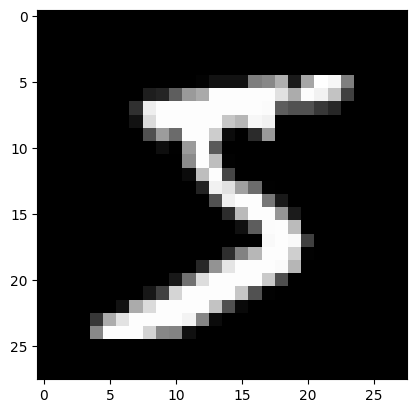

In [7]:
image, label = dataset[0]
plt.imshow(image, cmap='gray')
print('Label:', label)

Label: 1


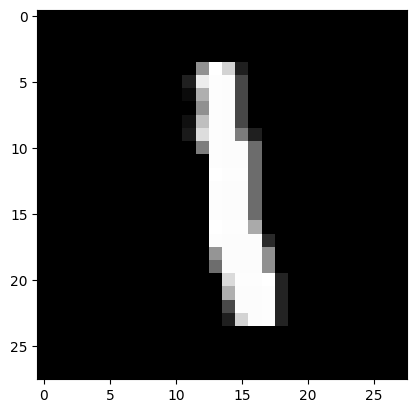

In [8]:
image, label = dataset[6]
plt.imshow(image, cmap='gray')
print('Label:', label)

In [9]:
import torchvision.transforms as transforms

In [10]:
dataset = MNIST(root='data/', 
                train=True, 
                transform=transforms.ToTensor())

In [11]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


In [12]:
print(img_tensor[0, 10:15, 10:15])

tensor([[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
        [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
        [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
        [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
        [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]])


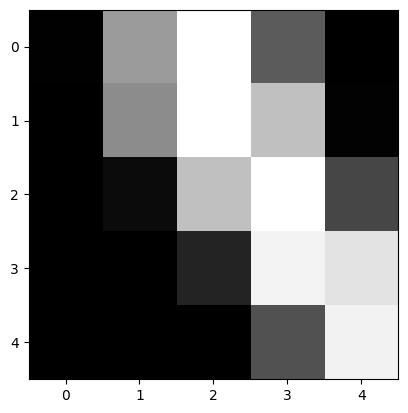

In [13]:
# Plot the image by passing in the 28x28 matrix
plt.imshow(img_tensor[0, 10:15, 10:15], cmap='gray');

## Training and Validation Datasets

In [14]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

We can now create data loaders to help us load the data in batches. We'll use a batch size of 128.

In [15]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

## Model

Since `nn.Linear` expects each training example to be a vector, each `1x28x28` image tensor is flattened into a vector of size 784 `(28*28)` before being passed into the model. 

The output for each image is a vector of size 10, with each element signifying the probability of a particular target label (i.e., 0 to 9). The predicted label for an image is simply the one with the highest probability.

In [16]:
import torch.nn as nn

In [20]:
input_size = 28 * 28
num_classes = 10

In [21]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
model = MnistModel()

In [22]:
model.linear
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0084, -0.0056,  0.0046,  ...,  0.0217, -0.0044, -0.0308],
         [ 0.0202, -0.0228,  0.0002,  ...,  0.0210,  0.0317,  0.0029],
         [-0.0183,  0.0245, -0.0041,  ...,  0.0158, -0.0305,  0.0189],
         ...,
         [ 0.0324,  0.0210,  0.0328,  ...,  0.0043, -0.0272, -0.0303],
         [-0.0006,  0.0341,  0.0074,  ..., -0.0207, -0.0099,  0.0201],
         [-0.0193, -0.0338, -0.0035,  ..., -0.0026, -0.0321, -0.0234]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0038,  0.0232,  0.0156,  0.0067,  0.0171, -0.0152,  0.0115, -0.0290,
          0.0221, -0.0095], requires_grad=True)]

In [23]:
for images, labels in train_loader:
    outputs = model(images)
    print(outputs)
    break

tensor([[-0.0988,  0.2021,  0.2486,  ..., -0.0241, -0.0012, -0.0324],
        [ 0.1088,  0.3484,  0.2922,  ...,  0.2263, -0.1214, -0.0450],
        [ 0.0668,  0.1253,  0.3808,  ...,  0.3590,  0.1584, -0.3428],
        ...,
        [ 0.1019,  0.0444,  0.0717,  ...,  0.1911,  0.0372, -0.1048],
        [ 0.2288, -0.4365, -0.1293,  ...,  0.3655, -0.1668, -0.4138],
        [ 0.2570, -0.0399,  0.1880,  ...,  0.3930, -0.0132, -0.0539]],
       grad_fn=<AddmmBackward0>)


For each of the input images, we get 10 outputs, one for each class. Since, we'd like these outputs to represent probabilities. Each output row's elements must lie between 0 and 1 and up to 1. 

To convert the outputs rows into probabilities, we use the softmax function

In [24]:
import torch.nn.functional as F

In [25]:
# Apply softmax for each output row
probs = F.softmax(outputs, dim=1)

# Print sample probabilities
print("Sample probabilities: \n", probs[:2].data)

# Add up the probabilities of an output row
print("Sum: ", torch.sum(probs[0]).item())

Sample probabilities: 
 tensor([[0.0851, 0.1150, 0.1205, 0.1191, 0.1052, 0.0827, 0.0958, 0.0917, 0.0938,
         0.0910],
        [0.1024, 0.1301, 0.1230, 0.0878, 0.0978, 0.0821, 0.0924, 0.1152, 0.0813,
         0.0878]])
Sum:  1.0


Finally, we can determine the predicted label for each image by simply choosing the index of the element with the highest probability in each output row. We can do this using torch.max, which returns each row's largest element and the corresponding index.

In [26]:
max_prob, preds = torch.max(probs, dim=1)
print(preds)
print(max_prob)

tensor([2, 1, 6, 0, 6, 3, 7, 7, 7, 0, 2, 0, 6, 3, 3, 6, 0, 7, 7, 7, 0, 1, 2, 7,
        1, 7, 0, 6, 7, 7, 6, 1, 0, 1, 0, 4, 8, 3, 7, 7, 0, 3, 6, 1, 0, 1, 8, 1,
        1, 6, 0, 7, 0, 1, 8, 3, 7, 7, 0, 1, 7, 1, 7, 7, 7, 7, 7, 2, 7, 1, 7, 0,
        2, 7, 9, 2, 7, 3, 0, 6, 2, 7, 7, 7, 8, 1, 1, 4, 1, 7, 0, 7, 0, 7, 6, 8,
        0, 7, 7, 7, 0, 2, 7, 7, 2, 7, 1, 6, 1, 7, 7, 1, 7, 6, 7, 0, 0, 7, 7, 0,
        8, 1, 1, 6, 1, 3, 7, 7])
tensor([0.1205, 0.1301, 0.1309, 0.1347, 0.1262, 0.1372, 0.1680, 0.1343, 0.1293,
        0.1319, 0.1270, 0.1277, 0.1390, 0.1202, 0.1247, 0.1267, 0.1293, 0.1340,
        0.1551, 0.1353, 0.1172, 0.1228, 0.1269, 0.1377, 0.1228, 0.1295, 0.1288,
        0.1298, 0.1344, 0.1380, 0.1230, 0.1105, 0.1337, 0.1414, 0.1151, 0.1169,
        0.1245, 0.1286, 0.1490, 0.1346, 0.1349, 0.1142, 0.1192, 0.1181, 0.1488,
        0.1328, 0.1226, 0.1344, 0.1429, 0.1304, 0.1240, 0.1342, 0.1285, 0.1333,
        0.1209, 0.1297, 0.1351, 0.1249, 0.1220, 0.1436, 0.1432, 0.1200, 0.1478,
       

In [27]:
x = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

In [28]:
torch.sum(x, dim=0)

tensor([12, 15, 18])

In [29]:
labels

tensor([8, 7, 0, 4, 3, 2, 2, 5, 9, 7, 9, 4, 2, 4, 1, 8, 8, 0, 2, 2, 4, 1, 4, 5,
        6, 1, 7, 5, 1, 6, 2, 3, 8, 5, 7, 2, 4, 8, 0, 3, 8, 2, 2, 1, 7, 1, 7, 3,
        1, 6, 9, 6, 3, 9, 0, 8, 8, 6, 7, 1, 9, 9, 9, 0, 0, 2, 3, 4, 4, 7, 4, 4,
        5, 9, 8, 9, 0, 2, 9, 0, 5, 0, 9, 5, 6, 1, 7, 5, 1, 6, 9, 6, 1, 0, 2, 1,
        9, 2, 4, 8, 9, 9, 4, 0, 9, 1, 1, 0, 9, 0, 2, 1, 9, 2, 1, 7, 4, 7, 2, 7,
        5, 1, 6, 2, 6, 0, 2, 7])

Most of the predicted labels are different from the actual labels. That's because we have just started with randomly initialized weights and biases. We still need to train the model i.e. adjust the weights using gradient descent to make better predictions

## Evaluation Metric and Loss Function

Just as with linear regression, we need a way to evaluate how well our model is performing - finding the percentage of correctly predicted labels seems obvious in this case.

In [30]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [31]:
accuracy(outputs, labels)

tensor(0.1016)

While the accuracy is an excellent choice for evaluating our model, it cannot be used as a loss function for optimizing our model using gradient descent because
- It's not a differentiable function
- It doesn't take into account the actual probabilities predicted by the model

A commonly used loss function for classification problems is the cross-entropy.

In [32]:
loss_fn = F.cross_entropy

In [33]:
# Loss for current batch of data
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.3265, grad_fn=<NllLossBackward0>)


In [35]:
outputs

tensor([[-0.0988,  0.2021,  0.2486,  ..., -0.0241, -0.0012, -0.0324],
        [ 0.1088,  0.3484,  0.2922,  ...,  0.2263, -0.1214, -0.0450],
        [ 0.0668,  0.1253,  0.3808,  ...,  0.3590,  0.1584, -0.3428],
        ...,
        [ 0.1019,  0.0444,  0.0717,  ...,  0.1911,  0.0372, -0.1048],
        [ 0.2288, -0.4365, -0.1293,  ...,  0.3655, -0.1668, -0.4138],
        [ 0.2570, -0.0399,  0.1880,  ...,  0.3930, -0.0132, -0.0539]],
       grad_fn=<AddmmBackward0>)

## Training the model

In [88]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

Let's define the `evaluate` function, used in the validation phase of `fit`

In [89]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

Finally, let's redefined the `MnistModel` class to include additional methods `training_step`, `validation_step`, `validation_epoch_end`, and `epoch_end` used by `fit` and `evaluate`. 

In [90]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                     # Generate predictions
        loss = F.cross_entropy(out, labels)    # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                     # Generate predictions
        loss = F.cross_entropy(out, labels)    # Calculate loss
        acc = accuracy(out, labels)            # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()      # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()         # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

Before we train the model, let's see how the model performs on the validation set with the initial set of random initialized weights and biases.

In [91]:
result0 = evaluate(model, val_loader)

In [92]:
result0

{'val_loss': 2.303903818130493, 'val_acc': 0.12094540894031525}

Let's now train the model for five epochs and look at the results

In [93]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9433, val_acc: 0.6278
Epoch [1], val_loss: 1.6766, val_acc: 0.7364
Epoch [2], val_loss: 1.4767, val_acc: 0.7693
Epoch [3], val_loss: 1.3259, val_acc: 0.7872
Epoch [4], val_loss: 1.2103, val_acc: 0.7975


Let's train for few more epochs

In [94]:
history2 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1196, val_acc: 0.8050
Epoch [1], val_loss: 1.0471, val_acc: 0.8123
Epoch [2], val_loss: 0.9879, val_acc: 0.8180
Epoch [3], val_loss: 0.9386, val_acc: 0.8225
Epoch [4], val_loss: 0.8971, val_acc: 0.8256


In [95]:
history3 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.8616, val_acc: 0.8282
Epoch [1], val_loss: 0.8308, val_acc: 0.8318
Epoch [2], val_loss: 0.8039, val_acc: 0.8337
Epoch [3], val_loss: 0.7802, val_acc: 0.8363
Epoch [4], val_loss: 0.7590, val_acc: 0.8384


In [96]:
history4 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7400, val_acc: 0.8404
Epoch [1], val_loss: 0.7229, val_acc: 0.8417
Epoch [2], val_loss: 0.7074, val_acc: 0.8430
Epoch [3], val_loss: 0.6932, val_acc: 0.8446
Epoch [4], val_loss: 0.6802, val_acc: 0.8456


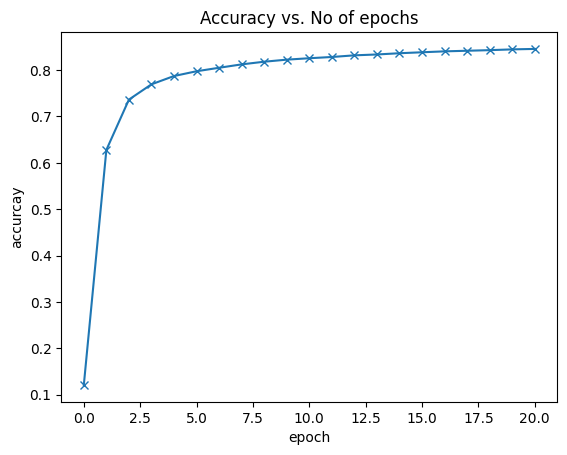

In [106]:
history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accurcay')
plt.title('Accuracy vs. No of epochs');

It's quite clear from the above picture that the model probably won't cross the accuracy threshold of 90% even after training for a very long time.  

## Testing with Individual Images

In [109]:
# Define test dataset
test_dataset = MNIST(root='data/', train=False, transform=transforms.ToTensor())

Shape: torch.Size([1, 28, 28])
Label: 7


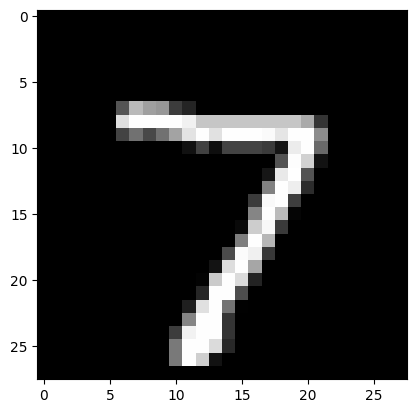

In [113]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)

In [127]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    
    return preds[0].item()

Label: 7 , Predicted: 7


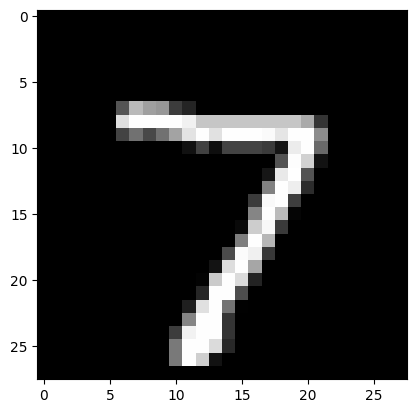

In [129]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 0 , Predicted: 0


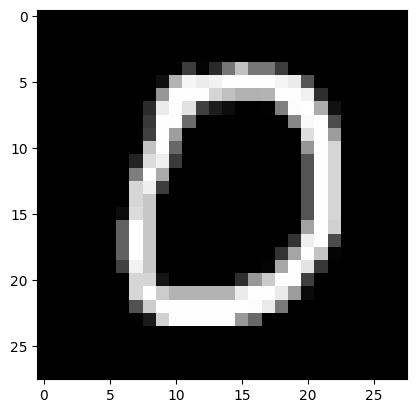

In [130]:
img, label = test_dataset[10]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 9


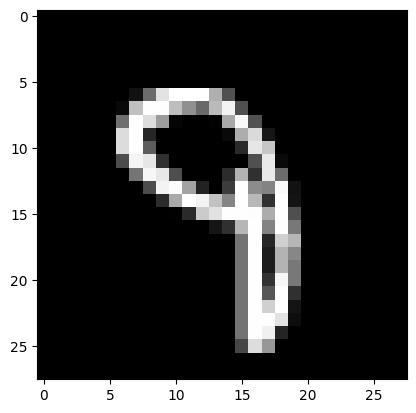

In [131]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 8


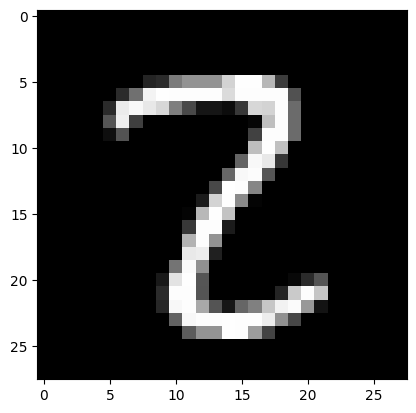

In [132]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

As a final step, let's also look at the overall loss and accuracy of the model on the test set.

In [133]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.6396650671958923, 'val_acc': 0.8609374761581421}

## Saving and loading the model

In [135]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

In [137]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0316,  0.0311,  0.0160,  ...,  0.0266, -0.0074,  0.0212],
                      [-0.0013,  0.0328, -0.0017,  ...,  0.0091, -0.0215, -0.0133],
                      [ 0.0192, -0.0055, -0.0338,  ...,  0.0048,  0.0269, -0.0264],
                      ...,
                      [-0.0309,  0.0015, -0.0205,  ..., -0.0206, -0.0156, -0.0017],
                      [ 0.0073, -0.0313, -0.0070,  ...,  0.0234, -0.0098,  0.0071],
                      [-0.0161, -0.0161,  0.0123,  ..., -0.0320, -0.0049,  0.0061]])),
             ('linear.bias',
              tensor([-0.0470,  0.1287, -0.0294, -0.0290,  0.0012,  0.0745,  0.0181,  0.0156,
                      -0.0726,  0.0030]))])

To load the model weights, we can instantiate a new object of the class MnistModel, and use the `.load_state_dict` method.

In [140]:
model2 = MnistModel()
model2.load_state_dict(torch.load('mnist-logistic.pth'))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0316,  0.0311,  0.0160,  ...,  0.0266, -0.0074,  0.0212],
                      [-0.0013,  0.0328, -0.0017,  ...,  0.0091, -0.0215, -0.0133],
                      [ 0.0192, -0.0055, -0.0338,  ...,  0.0048,  0.0269, -0.0264],
                      ...,
                      [-0.0309,  0.0015, -0.0205,  ..., -0.0206, -0.0156, -0.0017],
                      [ 0.0073, -0.0313, -0.0070,  ...,  0.0234, -0.0098,  0.0071],
                      [-0.0161, -0.0161,  0.0123,  ..., -0.0320, -0.0049,  0.0061]])),
             ('linear.bias',
              tensor([-0.0470,  0.1287, -0.0294, -0.0290,  0.0012,  0.0745,  0.0181,  0.0156,
                      -0.0726,  0.0030]))])

In [142]:
# Verify model has the same loss and accuracy on the test set as before
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model2, test_loader)
result

{'val_loss': 0.6396650671958923, 'val_acc': 0.8609374761581421}